In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt


import os
print(os.listdir("../input"))


['orders.csv', 'departments.csv', 'products.csv', 'order_products__train.csv', 'order_products__prior.csv', 'aisles.csv']


In [2]:
pd.options.display.max_rows = 20
%matplotlib inline
sns.set(style="whitegrid", palette ="colorblind", font_scale=1, rc={'font.family':'NanumGothic'})


In [3]:
def toReadable(v):
    value = round(v,2) if isinstance(v,float) else v
    
    if value < 1000:
        return str(value)
    elif value <1000000:
        return str(round(value/1000,1))+'K'
    elif value >=1000000:
        return str(round(value/1000000,1))+'M'
    return value

데이터 단위 수정

In [4]:
raw_order_ds = pd.read_csv('../input/orders.csv')
order_product_ds = pd.read_csv('../input/order_products__prior.csv')
product_ds = pd.read_csv('../input/products.csv')

order_product_cnt_ds = order_product_ds.groupby('order_id').count()[['product_id']]
order_product_cnt_ds.columns = ['product_cnt']

## join product count
order_ds = raw_order_ds.merge(order_product_cnt_ds, left_on = 'order_id', right_index = True)

In [5]:
## Summary of dataset
total_user = len(order_ds.user_id.unique())
total_order = len(order_ds)
total_ordered_product = len(order_product_ds)
unique_products = len(order_product_ds.product_id.unique())


print("total user = {}".format(toReadable(total_user)))
print("total order = {}({}orders per a user)".format(toReadable(total_order),toReadable(total_order/total_user)))
print("total product = ", toReadable(unique_products))
print("total ordered product = {}({} orders per a product)".format(
    toReadable(total_ordered_product),toReadable(total_ordered_product/unique_products) ))

total user = 206.2K
total order = 3.2M(15.59orders per a user)
total product =  49.7K
total ordered product = 32.4M(652.91 orders per a product)


In [6]:
index2day = "Sun Mon Tue Wed Thu Fri Sat".split()

In [7]:
def drawWeekHour (ds, values, aggfunc = len, title=None, figsize=(18,5), cmap=None):
    weekhour_ds = ds.pivot_table(index='order_dow', columns='order_hour_of_day', values=values, aggfunc=aggfunc).fillna(0)
    
    weekhour_ds.index = [index2day[index] for index in weekhour_ds.index]
    sns.set(style="whitegrid",palette="colorblind", font_scale=1, rc={'font.family':'NanumGothic'})
    
    plt.figure(figsize=figsize)
    f = sns.heatmap(weekhour_ds, annot=True, fmt="1.1f", linewidths=.5, cmap=cmap)
    plt.xlabel("Hour")
    plt.ylabel("Day of Week")
    if title:
        plt.title(title, fontsize=15)

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


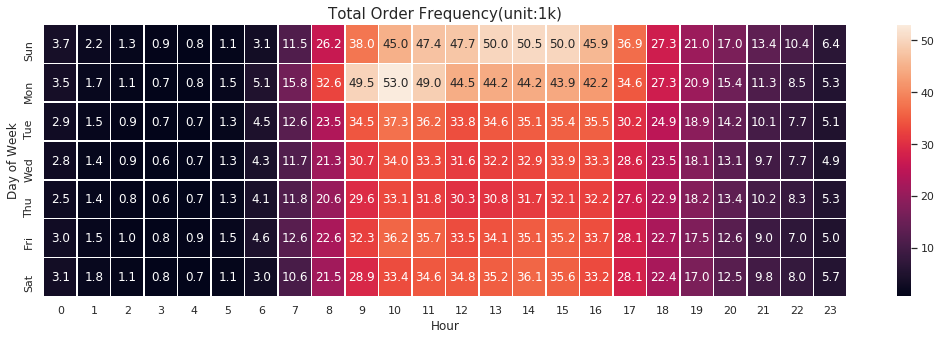

In [8]:
drawWeekHour(order_ds, values='order_id', title = "Total Order Frequency(unit:1k)", aggfunc=lambda x: len(x)/1000)

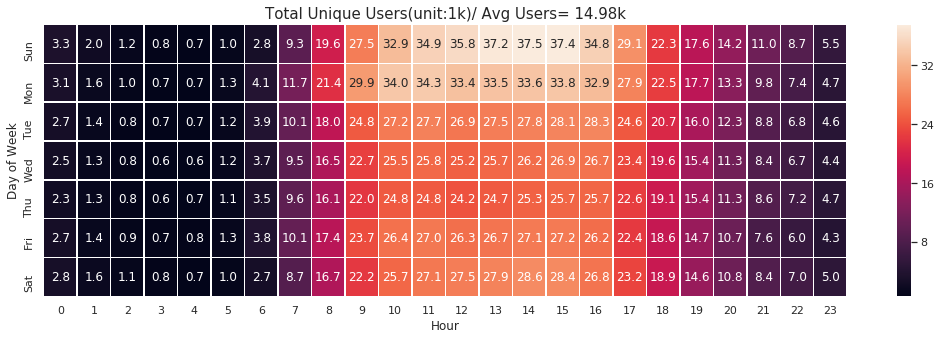

In [9]:
avg_users = round(order_ds.groupby(['order_dow','order_hour_of_day']).agg({'user_id':lambda x:len(x.unique())/1000
                                                                          }).mean().values[0],2)
drawWeekHour(order_ds, values='user_id',title="Total Unique Users(unit:1k)/ Avg Users= {}k".format(avg_users), aggfunc=lambda
             x: len(x.unique())/1000)

고객당 주문 건수(한 고객이 많이 사는건지 아니면 고객이 많아서 주문량이 많은건지 확인하기 위해)

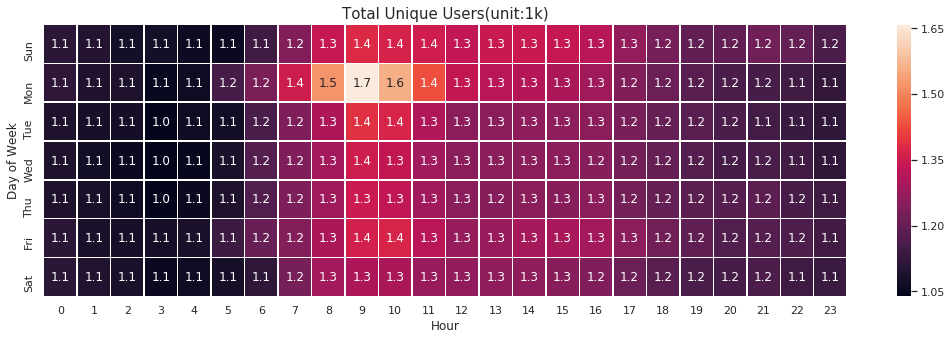

In [10]:
drawWeekHour(order_ds, values='user_id', title="Total Unique Users(unit:1k)"
            ,aggfunc=lambda x: len(x)/len(x.unique()))

특정한 한 사람이 정기적인 시간대에 많이 구매하는 것인지 아니면 주문량이 많아서 그런것인지 확인하기 위해
-> 주문량이 많은 것으로 보임

In [11]:
merge_order_product_ds = order_product_ds.merge(order_ds, on='order_id')
merge_order_product_ds = merge_order_product_ds.merge(product_ds, on='product_id')

In [12]:
hour_9_order_product_ds = merge_order_product_ds[merge_order_product_ds.order_hour_of_day==9]
grouped = hour_9_order_product_ds[:].groupby(['order_dow'])


월요일 오전 9시에는 어떤 물건을 많이 사는지 알아보기

In [13]:
topn =20
hour_9_popular_product =[]
for (dow,rows) in grouped:
    sub_ds = rows.groupby('product_id', as_index = False).agg({'order_id':len}).sort_values('order_id',
                                                                                           ascending=False)[:topn]
    sub_ds['dow']= dow
    sub_ds['rank']= list(range(0,topn))
    hour_9_popular_product.append(sub_ds)



In [14]:
hour_9_popular_product_ds = pd.concat(hour_9_popular_product).sort_values(['rank','dow']).merge(product_ds, on='product_id')\
.pivot(index='dow',columns='rank',values='product_name')
hour_9_popular_product_ds.index = index2day


In [15]:
hour_9_popular_product_ds

rank,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Sun,Banana,Bag of Organic Bananas,Organic Baby Spinach,Organic Strawberries,Organic Hass Avocado,Organic Avocado,Large Lemon,Limes,Strawberries,Organic Whole Milk,Organic Raspberries,Organic Yellow Onion,Organic Zucchini,Organic Garlic,Cucumber Kirby,Organic Grape Tomatoes,Apple Honeycrisp Organic,Organic Blueberries,Yellow Onions,Honeycrisp Apple
Mon,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado,Organic Avocado,Strawberries,Large Lemon,Organic Raspberries,Organic Half & Half,Organic Fuji Apple,Organic Whole Milk,Sparkling Water Grapefruit,Half & Half,Limes,Honeycrisp Apple,Apple Honeycrisp Organic,Organic Yellow Onion,Organic Blueberries,Seedless Red Grapes
Tue,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado,Organic Avocado,Strawberries,Organic Raspberries,Organic Whole Milk,Large Lemon,Organic Half & Half,Organic Fuji Apple,Limes,Half & Half,Organic Yellow Onion,Sparkling Water Grapefruit,Organic Blueberries,Organic Garlic,Organic Zucchini,Apple Honeycrisp Organic
Wed,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado,Strawberries,Organic Avocado,Organic Raspberries,Organic Whole Milk,Large Lemon,Limes,Organic Half & Half,Organic Blueberries,Organic Fuji Apple,Organic Yellow Onion,Organic Garlic,Sparkling Water Grapefruit,Half & Half,Apple Honeycrisp Organic,Organic Zucchini
Thu,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado,Organic Avocado,Strawberries,Organic Raspberries,Organic Whole Milk,Large Lemon,Limes,Organic Half & Half,Organic Fuji Apple,Organic Blueberries,Organic Zucchini,Organic Yellow Onion,Half & Half,Organic Garlic,Sparkling Water Grapefruit,Cucumber Kirby
Fri,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado,Strawberries,Organic Avocado,Organic Raspberries,Organic Whole Milk,Large Lemon,Limes,Organic Blueberries,Organic Yellow Onion,Organic Half & Half,Organic Fuji Apple,Organic Garlic,Organic Zucchini,Apple Honeycrisp Organic,Half & Half,Seedless Red Grapes
Sat,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado,Organic Avocado,Large Lemon,Limes,Organic Whole Milk,Strawberries,Organic Raspberries,Organic Yellow Onion,Organic Garlic,Organic Zucchini,Organic Blueberries,Cucumber Kirby,Organic Lemon,Yellow Onions,Organic Grape Tomatoes,Honeycrisp Apple


제일 많이 팔리는 물품 20개

시간대별 많이 팔리는 상품 20가지

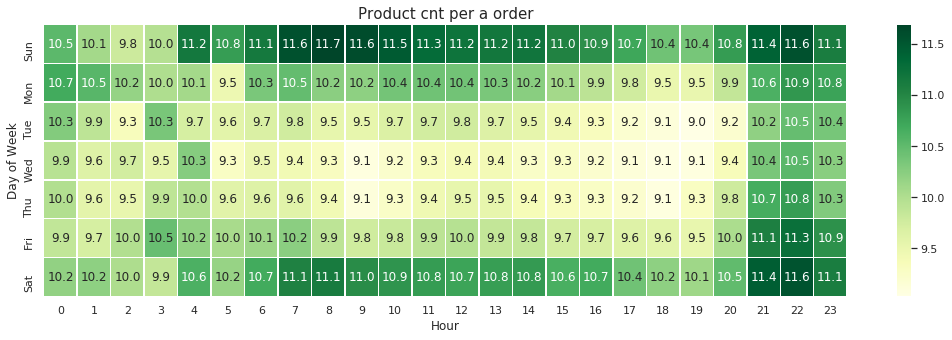

In [16]:
drawWeekHour(order_ds, values='product_cnt', title="Product cnt per a order", aggfunc=lambda x:np.mean(x), cmap='YlGn')

수치가 작을 수록 주문과 다음 주문까지의 경과되는 기간 일수가 작음(자주 주문한다고 볼 수 있음)

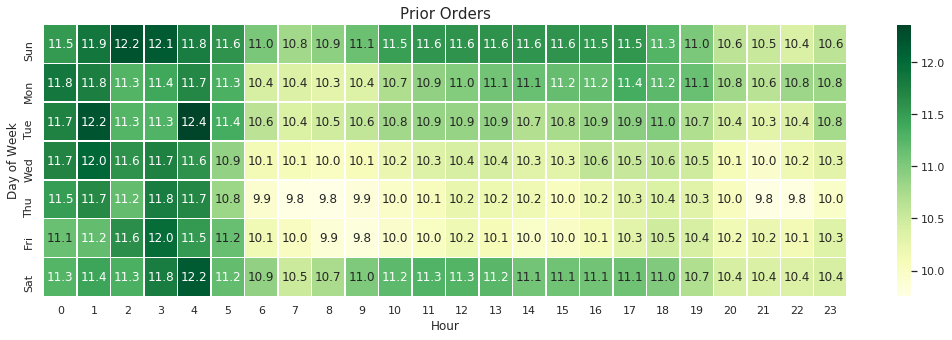

In [17]:
drawWeekHour(order_ds,values='days_since_prior_order', title="Prior Orders",aggfunc=lambda x: np.mean(x),cmap ='YlGn')

유저별 주문 빈도와 재 주문 경과된 시간 관계 = days_since_prior_order
-> 주문 횟수가 많다는 것은 충성 고객이라 추정할 수 있고, 따라서 재 주문 경과 일수가 짧은것으로 볼 수 있다.

In [18]:
print("Average day_since_prior_order {} Days".format( round(order_ds.days_since_prior_order.mean(),2)))

Average day_since_prior_order 10.71 Days


평균 10.71일로 주문 텀이 있다고 볼 수 있다.

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


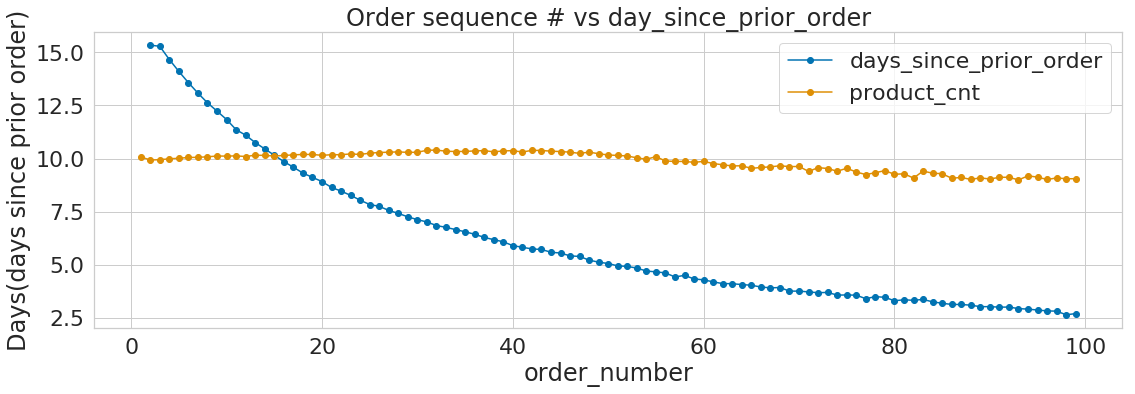

In [19]:
sns.set(style="whitegrid", palette = "colorblind", font_scale=2, rc={'font.family':'NanumGothic'})

order_ds.groupby('order_number').agg({'days_since_prior_order':np.mean, 'product_cnt':np.mean})\
.plot(figsize=(16,6), title="Order sequence # vs day_since_prior_order", marker='o')
plt.ylabel('Days(days since prior order)')
plt.tight_layout()
plt.show()

재주문 기간이 짧을 수록 이전 주문에서 구매했던 상품이 많을까?

In [20]:
merge_order_product_ds = order_product_ds.merge(order_ds, on='order_id')

In [21]:
reordered_since_days_ds = merge_order_product_ds.groupby(['days_since_prior_order','reordered']).agg({'product_id' :len})

reordered_since_days_ds = reordered_since_days_ds.reset_index().pivot(index='days_since_prior_order',
                                                                     columns='reordered', values = 'product_id')

reordered_since_days_ds['reorder_rate'] = reordered_since_days_ds[1] / reordered_since_days_ds.sum(axis=1)
avg_reordered_rate = round(reordered_since_days_ds[1].sum() / reordered_since_days_ds[[0,1]].sum().sum(),2)
                                                                                                    

다시 주문하는 기간이 짧을 수록 재구매 상품 비율이 높다
-평균 대비 5%정도

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


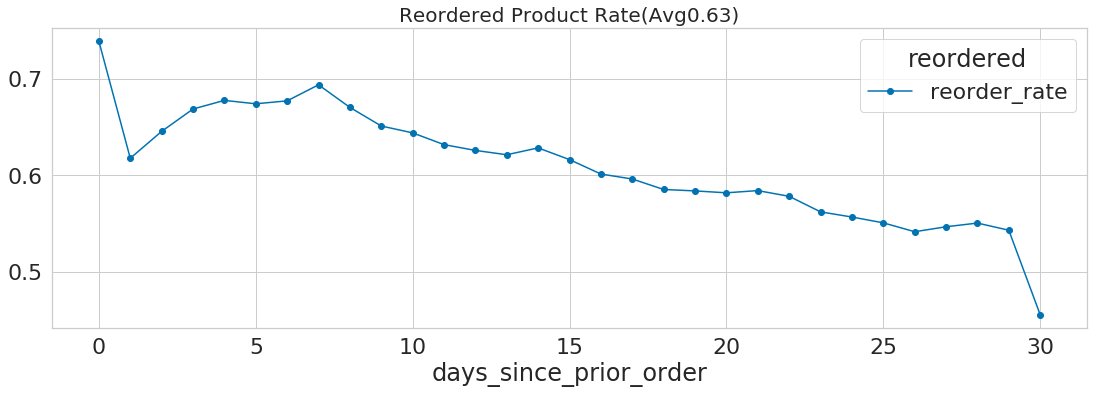

In [22]:
reordered_since_days_ds[['reorder_rate']].plot(kind='line', marker='o', figsize=(16,6))

plt.title("Reordered Product Rate(Avg{})".format(avg_reordered_rate), fontsize=20)
plt.tight_layout()
plt.show()

많이 주문을 한 경우에는 재구매 상품이 많을지

In [23]:
reordered_order_num_ds = merge_order_product_ds.groupby(['order_number','reordered']).agg({'product_id':len})
reordered_order_num_ds = reordered_order_num_ds.reset_index().pivot(index='order_number', columns = 'reordered',values =
                                                                   'product_id')

reordered_order_num_ds['reorder_rate'] = reordered_order_num_ds[1] / reordered_order_num_ds.sum(axis=1)
avg_reorderd_rate = round(reordered_order_num_ds[1].sum() / reordered_order_num_ds[[0,1]].sum().sum(),2)
reordered_order_num_ds.fillna(0,inplace=True)

<function matplotlib.pyplot.show(*args, **kw)>

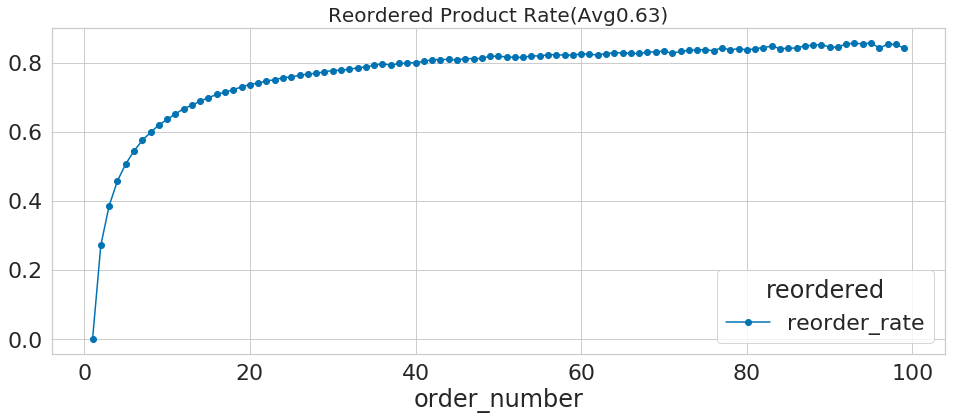

In [24]:
reordered_order_num_ds[['reorder_rate']].plot(kind='line', marker='o', figsize=(16,6))
plt.title("Reordered Product Rate(Avg{})".format(avg_reordered_rate), fontsize = 20)
plt.show

위의 그래프를 보면 로그함수 형태를 띄고 있고 40번 이상 주문한 사람은 재구매 상품이 80%이상임을 알 수 있다.

이제 어떤 상품들이 재주문 비율이 높은지 확인해보도록 함

In [25]:
product_reorder_ds = merge_order_product_ds.groupby(['product_id']).agg({'order_id':len,
                                                                        'reordered':lambda x: len(x[x>0]),
                                                                        'user_id' :lambda x: len(x.unique())})

In [26]:
convert_colnames = {'user_id': 'unique_users','reordered':'reorder','order_id':'total_order'}
product_reorder_ds.columns = [convert_colnames[col] for col in product_reorder_ds.columns]

In [27]:
product_reorder_ds['reorder_rate'] = round(product_reorder_ds.reorder / product_reorder_ds.total_order,2)
product_reorder_ds['orders_per_user'] = round(product_reorder_ds.total_order / product_reorder_ds.unique_users,2)
product_reorder_ds = product_reorder_ds.merge(product_ds, left_index = True, right_on = 'product_id')

In [28]:
product_reorder_ds[product_reorder_ds.total_order>1000].sort_values('reorder_rate', ascending=False)\
    [['product_name','total_order', 'reorder_rate', 'aisle_id','orders_per_user']][:20]

,product_name,total_order,reorder_rate,aisle_id,orders_per_user
45503,Whole Organic Omega 3 Milk,9108,0.86,84,7.15
9291,Half And Half Ultra Pasteurized,2921,0.86,84,7.23
47230,Ultra-Purified Water,1489,0.86,115,7.02
5513,Organic Homogenized Whole Milk,3970,0.86,84,7.03
43393,Organic Lactose Free Whole Milk,8477,0.86,91,7.09
34196,Goat Milk,5185,0.85,84,6.66
29446,"Milk, Organic, Vitamin D",20198,0.85,84,6.87
38688,Organic Reduced Fat Milk,35663,0.85,84,6.70
31719,Organic Whole Milk,9842,0.84,84,6.30
24520,Lowfat Goat Milk,1159,0.84,84,6.20


aisle별 재구매 상품 비율 상위20개와 하위 20개 나타내기

In [29]:
from collections import defaultdict
import operator

def popularWords(names, topn=2):
    wordFrequency = defaultdict(int)
    def updateWords(words):
        for word in words : 
            if len(word)>1:
                wordFrequency[word] +=1
    names.apply(lambda x: updateWords(x.split()))
    tops = sorted(wordFrequency.items(), key=operator.itemgetter(1),reverse=True)[:topn]
    return " ".join([n[0] for n in tops])

In [30]:
aisle_ds = product_ds.groupby('aisle_id').agg({'product_name':popularWords
                                              , 'product_id' : lambda x: len(x.unique())})

In [31]:
aisle_order_stat_ds = product_reorder_ds.groupby('aisle_id').agg({'total_order':sum, 'reorder':sum})

aisle_order_stat_ds['reorder_rate'] = round(aisle_order_stat_ds.reorder / aisle_order_stat_ds.total_order, 2)

aisle_order_stat_ds = aisle_order_stat_ds.merge(aisle_ds, left_index=True, right_index=True).sort_values('reorder_rate',
                                                                                                        ascending=False)
aisle_order_stat_ds.index = aisle_order_stat_ds.product_name + "("+ aisle_order_stat_ds.index.astype(str)+")"

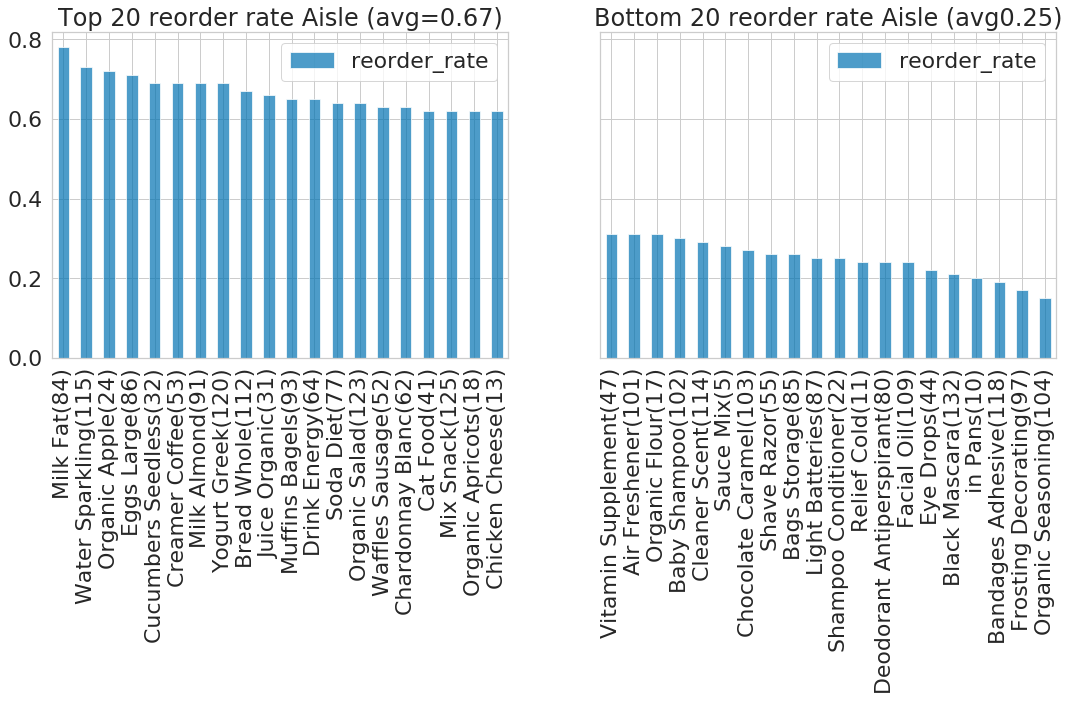

In [32]:
sns.set(style="whitegrid", palette="colorblind",font_scale=2)

f, (ax1,ax2) = plt.subplots(1,2, sharey=True)

top20_ds = aisle_order_stat_ds[['reorder_rate']][:20]
top20_ds.plot(kind='bar', figsize=(16,6), alpha=.7, ax=ax1, title='Top 20 reorder rate Aisle (avg={})'
             .format(toReadable(top20_ds.reorder_rate.mean())))

bottom20_ds = aisle_order_stat_ds[['reorder_rate']][-20:]
bottom20_ds.plot(kind='bar', figsize=(18,6), alpha=.7, ax=ax2, title='Bottom 20 reorder rate Aisle (avg{})'.format
                (toReadable(bottom20_ds.reorder_rate.mean())))
plt.show()

주문이 많은 상품은 재구매율이 높은지 확인해보기 재구매율과 총주문수는 데이터 단위 차이가 많이 나기 때문에 스피어만 상관계수를 적용.

상관계수 1값에 가까울수록 두 데이터간 상관관계가 있다고 볼 수 있다.

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.6/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.

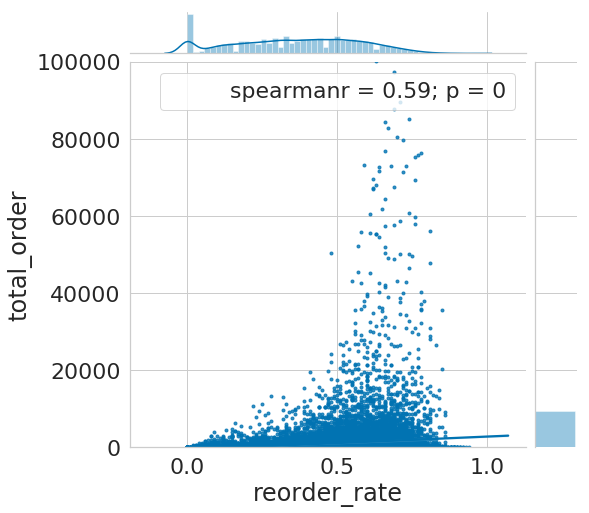

In [33]:
from scipy.stats import spearmanr
g= sns.jointplot("reorder_rate", "total_order", kind="reg", marker='.', ylim=(0,100000), size=8, ratio=8,
                stat_func=spearmanr, data=product_reorder_ds)

상관계수 약 0.6 이므로 두 데이터간 상관관계가 있다고 볼 수 있다.

Word2vec으로 Item2vec 만들기
word=product_id
sentence = order

In [34]:
order_product_list = merge_order_product_ds\
.sort_values(['user_id','order_id', 'add_to_cart_order'])[['order_id','product_id']]\
.values.tolist()

product_corpus = []
sentence =[]
new_order_id = order_product_list[0][0]
for(order_id, product_id) in order_product_list:
    if new_order_id != order_id:
        product_corpus.append(sentence)
        sentence=[]
        new_order_id = order_id
    sentence.append(str(product_id))

In [35]:
pip install paramiko


The following command must be run outside of the IPython shell:

    $ pip install paramiko

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [36]:

from gensim.models import Word2Vec

model = Word2Vec(product_corpus, size=100, window=6, min_count=200)

/opt/conda/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [37]:
def toProductName(id):
    return product_ds[product_ds.product_id==id]['product_name'].values.tolist()[0]
toProductName(24852)

'Banana'

In [38]:
def most_similar_readable(model, product_id):
    similar_list = [(product_id,1.0)]+model.wv.most_similar(str(product_id))
    
    return [( toProductName(int(id)),similarity) for (id,similarity)in similar_list]

바나나와 가장 비슷한 상품은?

In [39]:
pd.DataFrame(most_similar_readable(model,24852), columns=['product','similarity'])

,product,similarity
0,Banana,1.000000
1,Bag of Organic Bananas,0.689151
2,Bartlett Pears,0.580738
3,Seedless Red Grapes,0.571961
4,Granny Smith Apples,0.521966
5,XL Emerald White Seedless Grapes,0.518701
6,Organic Banana,0.511773
7,Total 0% Greek Yogurt,0.507577
8,Organic Fuji Apple,0.485708
9,Total 2% All Natural Plain Greek Yogurt,0.477582


In [40]:
pd.DataFrame(most_similar_readable(model, 48697), columns=['product','similarity'])

,product,similarity
0,Canola Oil,1.000000
1,Light Brown Sugar,0.746395
2,Unsalted Butter,0.727165
3,Unbleached Bread Flour,0.723548
4,Corn Starch,0.712953
5,Whole Wheat Flour,0.710317
6,Refined Canola Oil,0.709351
7,Panko Bread Crumbs,0.704450
8,Unbleached All-Purpose Flour,0.703535
9,Active Dry Yeast,0.697940
